In [50]:
import numpy as np
import matplotlib.pyplot as plt

In [51]:
# To simulate stock prices, we need some input parameters.
# setup params for brownian motion
s0 = 450.00
sigma = 0.3
mu = 0.35

# setup the simulation
paths = 1000
delta = 1.0/252.0
time = 252 * 5

# Start by defining the initial stock price, s0 (450.00 for SPY ETF). 
# Then sigma which is the percentage volatility. 
# Finally, mu (drift), which determine the overall trend.

# Setup the simulation with 1,000 simulation paths. 
# delta refers to the time step. 
# I want to model a new stock price every day so I use 1/252 to represent 1 day
# in 252 trading days. The length of the simulation is 5 years.

In [52]:
def wiener_process(delta, sigma, time, paths):
    """Returns a Wiener process
    
    Parameters
    ----------
    delta : float
        The increment to downsample sigma
    sigma : float
        Percentage volatility
    time : int
        Number of samples to create
    paths : int
        Number of price simulations to create
    
    Returns
    -------
    wiener_process : np.ndarray
    
    Notes
    -----
    This method returns a Wiener process. 
    The Wiener process is also called Brownian 
    motion. For more information about the 
    Wiener process check out the Wikipedia 
    page: http://en.wikipedia.org/wiki/Wiener_process
    """

    # return an array of samples from a normal distribution
    return sigma * np.random.normal(loc=0, scale=np.sqrt(delta), size=(time, paths))

In [53]:
def gbm_returns(delta, sigma, time, mu, paths):
    """Returns from a Geometric brownian motion
    
    Parameters
    ----------
    delta : float
        The increment to downsample sigma
    sigma : float
        Percentage volatility
    time : int
        Number of samples to create
    mu : float
        Percentage drift
    paths : int
        Number of price simulations to create
    
    Returns
    -------
    gbm_returns : np.ndarray
    
    Notes
    -----
    This method constructs random Geometric Brownian 
    Motion (GBM).
    """
    process = wiener_process(delta, sigma, time, paths)
    return np.exp(
        process + (mu - sigma**2 / 2) * delta
    )

In [54]:
def gbm_levels(s0, delta, sigma, time, mu, paths):
    """Returns price paths starting at s0
    
    Parameters
    ----------
    s0 : float
        The starting stock price
    delta : float
        The increment to downsample sigma
    sigma : float
        Percentage volatility
    time : int
        Number of samples to create
    mu : float
        Percentage drift
    paths : int
        Number of price simulations to create
    
    Returns
    -------
    gbm_levels : np.ndarray
    """
    returns = gbm_returns(delta, sigma, time, mu, paths)

    stacked = np.vstack([np.ones(paths), returns])
    return s0 * stacked.cumprod(axis=0)

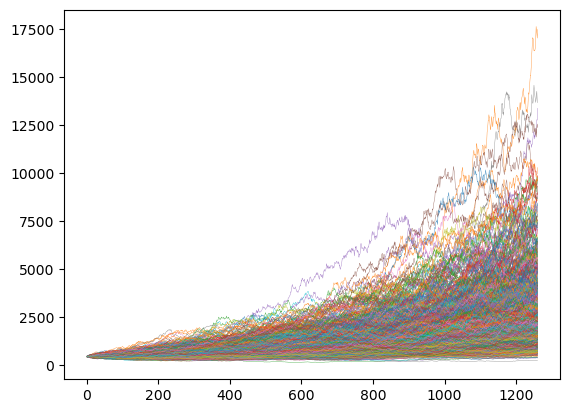

In [55]:
price_paths = gbm_levels(s0, delta, sigma, time, mu, paths)
plt.plot(price_paths, linewidth=0.25)
plt.show()

In [56]:
# As you might expect, a 35% drift causes most price paths to increase 
# from from the initial price. 
# In fact we can test exactly how many have increased from the initial price.

len(price_paths[-1, price_paths[-1, :] > s0])

994

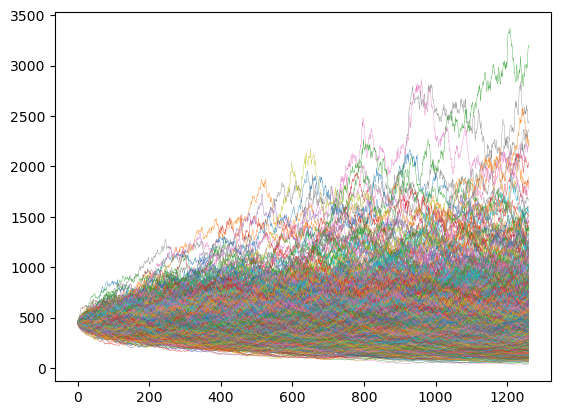

In [57]:
# In the second example I set the drift to 0.0.
price_paths = gbm_levels(s0, delta, sigma, time, 0.0, paths)
plt.plot(price_paths, linewidth=0.25)
plt.show()

In [58]:
# Create a pandas DataFrame from the simulated price paths
import pandas as pd

# Create date index for the simulation (252 trading days * 5 years)
start_date = '2020-01-01'
date_index = pd.date_range(start=start_date, periods=time+1, freq='B')  # 'B' for business days

# Convert price_paths to DataFrame
# Each column represents a different simulation path
# Note: price_paths already has the correct shape (time+1, paths)
df_prices = pd.DataFrame(
    price_paths,  # No transpose needed - rows are time, columns are paths
    columns=[f'Path_{i+1}' for i in range(paths)],
    index=date_index
)

print(f"DataFrame shape: {df_prices.shape}")
print(f"Date range: {df_prices.index.min()} to {df_prices.index.max()}")
print("\nFirst 5 rows and 5 columns:")
print(df_prices.iloc[:5, :5])

print(f"\nFinal prices statistics:")
print(df_prices.iloc[-1].describe())

DataFrame shape: (1261, 1000)
Date range: 2020-01-01 00:00:00 to 2024-10-30 00:00:00

First 5 rows and 5 columns:
                Path_1      Path_2      Path_3      Path_4      Path_5
2020-01-01  450.000000  450.000000  450.000000  450.000000  450.000000
2020-01-02  460.684146  457.212881  462.755925  459.497490  450.031227
2020-01-03  459.997654  458.204710  495.584125  450.865325  442.725174
2020-01-06  461.860088  451.604214  485.612823  461.303063  431.078839
2020-01-07  467.413679  456.647413  486.690198  451.615489  438.614825

Final prices statistics:
count    1000.000000
mean      456.029969
std       335.477653
min        36.852723
25%       239.629571
50%       374.669006
75%       569.551281
max      3184.753563
Name: 2024-10-30 00:00:00, dtype: float64


In [59]:
# # Debug: Check dimensions before creating DataFrame
# print("Debugging dimensions:")
# print(f"price_paths shape: {price_paths.shape}")
# print(f"time parameter: {time}")
# print(f"paths parameter: {paths}")
# print(f"Expected DataFrame shape: ({time+1}, {paths})")
# print(f"Date index length: {len(pd.date_range(start='2020-01-01', periods=time+1, freq='B'))}")
# print(f"Number of columns needed: {paths}")
# print("✓ Everything should match now!")

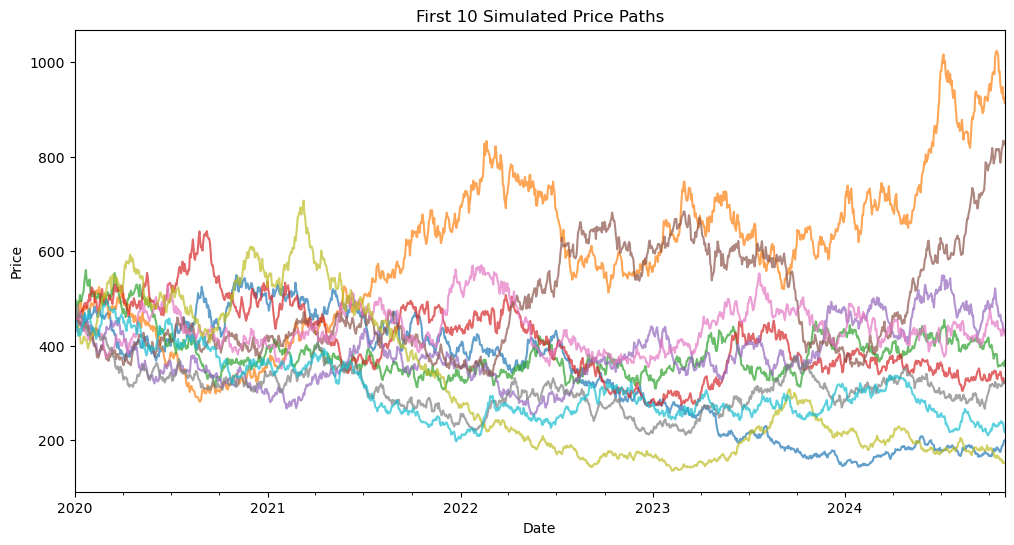

Price statistics across all paths:
                  Mean      Median         Std        Min          Max
2024-10-24  456.164084  374.868238  332.214998  35.240125  2978.889188
2024-10-25  456.388617  373.129666  333.679653  34.488935  3077.523855
2024-10-28  456.028350  373.316894  333.404340  35.618735  3146.997821
2024-10-29  455.819696  373.559196  334.494410  36.366755  3202.092710
2024-10-30  456.029969  374.669006  335.477653  36.852723  3184.753563


In [60]:
# Additional useful DataFrame operations

# 1. Calculate daily returns for each path
df_returns = df_prices.pct_change().dropna()

# 2. Calculate cumulative returns from initial price
df_cum_returns = (df_prices / s0) - 1

# 3. Plot a subset of paths using pandas plotting
df_prices.iloc[:, :10].plot(figsize=(12, 6), alpha=0.7, legend=False)
plt.title('First 10 Simulated Price Paths')
plt.ylabel('Price')
plt.xlabel('Date')
plt.show()

# 4. Calculate statistics across all paths for each time period
price_stats = pd.DataFrame({
    'Mean': df_prices.mean(axis=1),
    'Median': df_prices.median(axis=1),
    'Std': df_prices.std(axis=1),
    'Min': df_prices.min(axis=1),
    'Max': df_prices.max(axis=1)
})

print("Price statistics across all paths:")
print(price_stats.tail())

In [61]:
# # Saving and loading the simulated data

# # Save to CSV (all paths)
# # df_prices.to_csv('simulated_stock_prices.csv')

# # Save to CSV (subset of paths to reduce file size)
# df_prices.iloc[:, :100].to_csv('simulated_stock_prices_sample.csv')

# # Save summary statistics instead of all paths
# price_stats.to_csv('simulated_price_statistics.csv')

# print("Data saved successfully!")
# print(f"Full dataset shape: {df_prices.shape}")
# print(f"Sample dataset shape: {df_prices.iloc[:, :100].shape}")

# # To load the data later:
# # df_loaded = pd.read_csv('simulated_stock_prices_sample.csv', index_col=0, parse_dates=True)